In [1]:
if (!require("igraph")) install.packages("igraph")
library ("igraph")
if (!require("clevr")) install.packages("clevr")
library ("clevr")

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: clevr

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘clevr’”
also installing the dependencies ‘Rcpp’, ‘BH’





The downloaded binary packages are in
	/var/folders/m6/4mgxnhd5575fll1p8n3_wcjc0000gn/T//RtmpEHkWWY/downloaded_packages


In [2]:
# Reading the csv files
path = "finance_data/data/"
out.file<-""
file.names <- dir(path, pattern =".csv")
m <- matrix(, nrow = 0, ncol = 765)
sectors.table <- read.table("finance_data/Name_sector.csv",header=TRUE, sep=",", stringsAsFactors=TRUE)
sectors = c()
sectors.names <- c()
for(i in 1:length(file.names)){
    file <- read.table(paste("finance_data/data/",file.names[i],sep = ""),header=TRUE, sep=",", stringsAsFactors=FALSE)
    if(length(file$Close)==765){
        m <- rbind(m, matrix(file$Close, nrow=1, ncol=765))
        mystr <- substr(file.names[i], 1, nchar(file.names[i])-4)
        sector <- sectors.table$Sector[which(sectors.table$Symbol == mystr)]
        sectors.names = c(sectors.names, toString(sector))
    }
}

In [8]:
# Printing the sector details
com_num = length(sectors.names)
data_num = ncol(m)
sector.set<-as.factor(sectors.names)
sectors.index<-as.numeric(sector.set)
num_sector <- length(unique(sectors.index))
table(sector.set)

sector.set
    Consumer Discretionary           Consumer Staples 
                        84                         36 
                    Energy                 Financials 
                        34                         63 
               Health Care                Industrials 
                        60                         64 
    Information Technology                  Materials 
                        66                         24 
               Real Estate Telecommunication Services 
                        31                          4 
                 Utilities 
                        28 

QUESTION 1: What are upper and lower bounds on $ρ_{ij}$? Provide a justification for using log- normalized return ($r_i(t)$) instead of regular return ($q_i(t)$).

[I'm stumped on this.]  
The lower bound of $\rho_{ij}$ can be found when $q_i(t)$ and $q_j(t)$ go to -1. This can occur when $p_i(t)$ is 0 and $p_i(t-1)$ is not 0. If this is the case, then $r_i(t) = log(1-1) = -\infty$.  
  
One reason why $r_i(t)$ may be used instead of $q_i(t)$ is because if there is no change in the regular return values, and if those were to be used, then $\rho_{ij}$ would be undefined. Otherwise there could be 0 in the denominator.

QUESTION 2: Plot a histogram showing the un-normalized distribution of edge weights.

In [3]:
# Processing the files with p,q,r computations for the daily stock market data
allcomp = read.csv("finance_data/Name_sector.csv", header=TRUE, stringsAsFactors=FALSE)
filenames <- list.files("finance_data/data", pattern="*.csv")
filenames = paste("finance_data/data", filenames, sep="/")

L=c()
k=1
mat = matrix(0,length(filenames)-11,764)
for(j in c(1:length(filenames))){
    df = read.csv(filenames[j],header=TRUE, stringsAsFactors=FALSE)
    L[j] = dim(df)[1]
    if(L[j]==765){
        p = df[,5] 
        q = c()
        r = c()
        for(i in c(2:length(p))){
            q[i-1] = (p[i]-p[i-1])/p[i-1]
        }
        r = log(1+q)
        mat[k,] = r
        k = k+1
    }
}

allcomp["length"] = L
ind = which(L!=765)

allcomp <- allcomp[-ind,]

In [4]:
# Helper function for correlation computation
cal_cor <- function(conn, mat, allcomp){
    numCom = dim(mat)[1]
    cat("from","\t","to","\t","wt",file=conn)
    for(i in c(1:(numCom-1))){
        for(j in c((i+1):numCom)){
            ri = mean(mat[i,])
            rj = mean(mat[j,])
            mult = mean(mat[i,]*mat[j,])
            num = mult-(ri*rj)
            ri2 = mat[i,]^2
            rj2 = mat[j,]^2
            den = sqrt((mean(ri2)-(ri^2))*(mean(rj2)-(rj^2)))
            pij = num/den
            wij = sqrt(2*(1-pij))
            #val = 
            cat('\n',allcomp[i,1],'\t',allcomp[j,1],'\t',wij,file=conn)
        }
    }
}

In [5]:
# Creating the correlation graph
conn <- file("edgelist.txt", "w")
cal_cor(conn, mat, allcomp)
close(conn)
elist <-read.delim("edgelist.txt",header=TRUE)
g <- graph.data.frame(elist, directed = FALSE)
E(g)$weight <- elist[,"wt"]

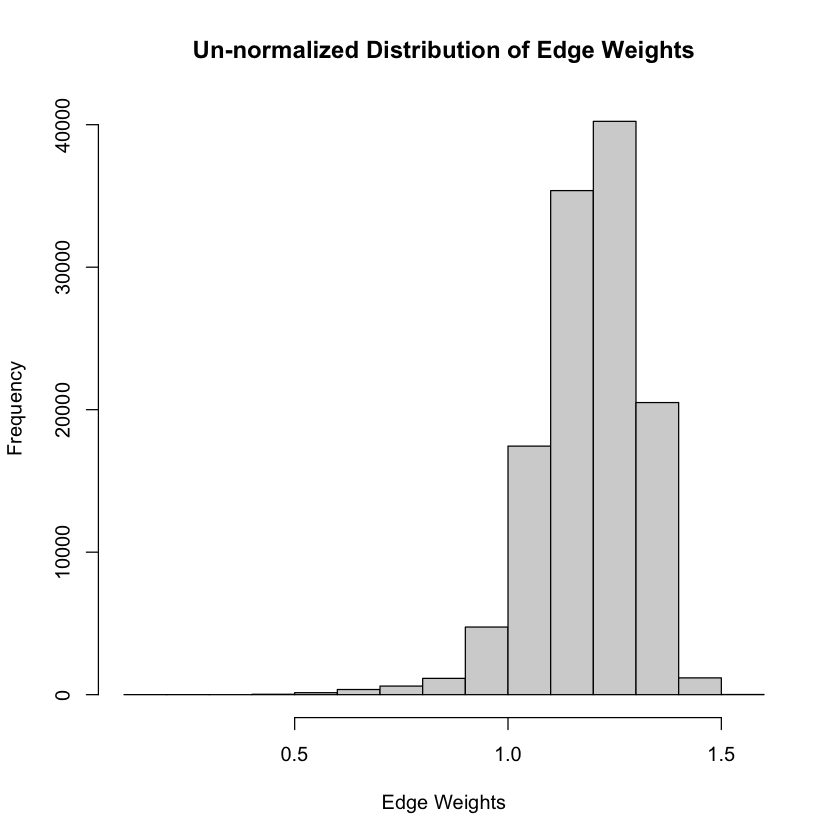

In [6]:
# Plotting the un-normalized distribution of edge weights
hist(elist[,"wt"],main="Un-normalized Distribution of Edge Weights",xlab="Edge Weights",ylab="Frequency")

QUESTION 3: Extract the MST of the correlation graph. Each stock can be categorized into a sector, which can be found in Name sector.csv file. Plot the MST and color-code the nodes based on sectors. Do you see any pattern in the MST? The structures that you find in MST are called Vine clusters. Provide a detailed explanation about the pattern you observe.

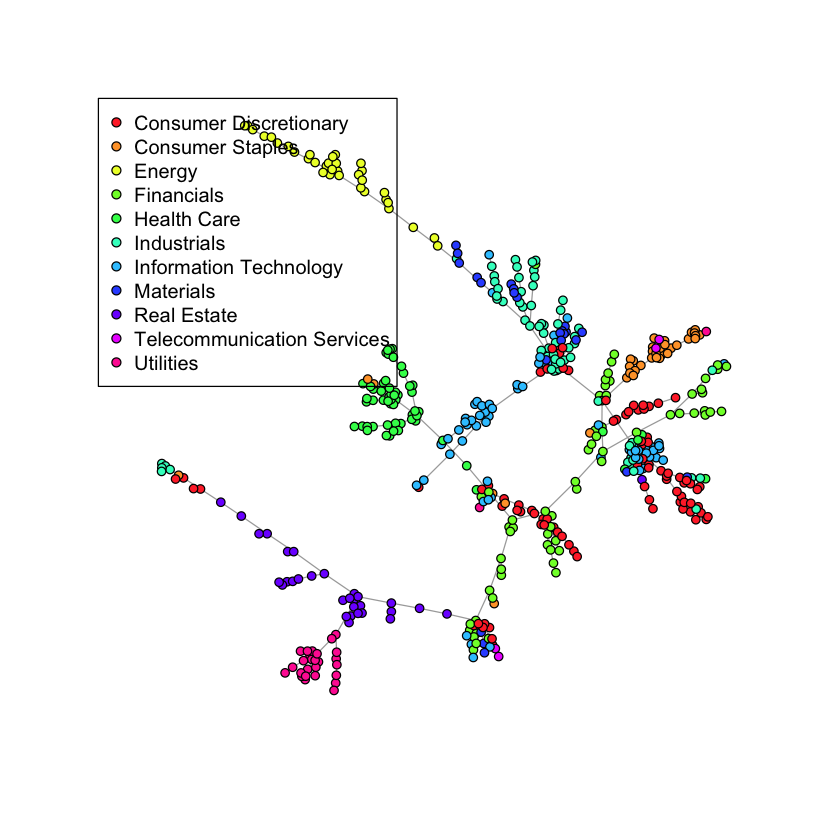

In [9]:
# Extracting and plotting the minimum spanning tree of the correlation graph
mst_g <- mst(g, algorithm = 'prim')
colbar <- rainbow(num_sector,s = 0.8, v = 1)
plot(mst_g, vertex.size=3, vertex.label=NA, vertex.color=colbar[sectors.index])
legend('topleft',legend=levels(sector.set),pch=21, pt.bg=colbar)

A pattern that can be seen is that the nodes with the same sector coloring tend to be grouped together in the vine clusters of the tree.

QUESTION 4: Run a community detection algorithm (for example walktrap) on the MST ob- tained above. Plot the communities formed. Compute the homogeneity and completeness of the clustering. (you can use the ’clevr’ library in r to compute homogeneity and completeness).

[1] 33

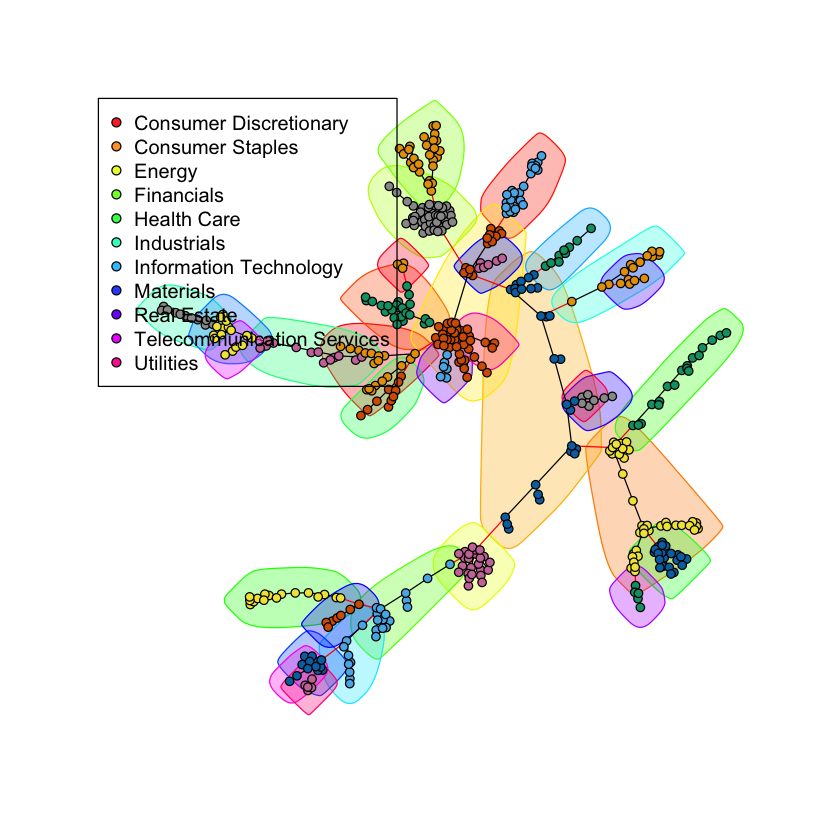

In [11]:
# Clustering of correlation graph
wc_daily <- walktrap.community(mst_g, weights= E(mst_g)$weights, modularity = TRUE) 
length(wc_daily)
plot(wc_daily, mst_g, vertex.size=3, vertex.label=NA, vertex.color=sectors.index)
legend('topleft',legend=levels(sector.set),pch=21, pt.bg=colbar)

In [12]:
# Computing the homogeneity and completeness of the clustering
true<- c(sectors.index)
pred <- c(wc_daily$membership)
homogeneity(true, pred)
completeness(true,pred)

[1] 0.6826446

[1] 0.4792845

QUESTION 5: Report the value of α for the two cases and provide an interpretation for
the difference.

In [103]:
card_V = length(V(mst_g))
sum1 = 0
sum2 = 0
for(v in V(mst_g)){
    card_N = length(neighbors(mst_g,v))
    v_sect = sectors.index[v]
    card_Q = 0
    for(n in neighbors(mst_g, v)){
        if(sectors.index[n] == v_sect){
            card_Q = card_Q + 1
        }
    }
    card_S = length(sectors.index[sectors.index==v_sect])
    p1 = card_Q / card_N
    p2 = card_S / card_V
    sum1 = sum1 + p1
    sum2 = sum2 + p2
}
alpha1 = sum1 / card_V
alpha2 = sum2 / card_V
print("Alpha with first definition of P:")
print(alpha1)
print("Alpha with second definition of P:")
print(alpha2)

[1] "Alpha with first definition of P:"
[1] 0.8289301
[1] "Alpha with second definition of P:"
[1] 0.1141881


For the first case, P is the fraction of neighbors that are in the same sector out of all the neighbors. For the second case, P is the fraction of all nodes that are in the same sector out of all nodes. The second case is a much smaller fraction with the largest number of nodes in a given sector being 84 which is less than a fifth of all nodes. Since the nodes are well-clustered based on sector, the first case has a relatively high value.

QUESTION 6: Repeat questions 2,3,4,5 on the WEEKLY data.

In [105]:
# Processing the files with p,q,r computations for the weekly stock market data
df["Day"] <-weekdays(as.Date(df[,1]))
L=c()
k=1
matw = matrix(0,length(filenames)-6,142)
for(j in c(1:length(filenames))){
    df = read.csv(filenames[j],header=TRUE, stringsAsFactors=FALSE)
    df["Day"]<-weekdays(as.Date(df[,1])) 
    df <- subset(df, Day=='Monday')
    L[j] = dim(df)[1]
    if(L[j]==143){
        p = df[,5] 
        q = c()
        r = c()
        for(i in c(2:length(p))){
            q[i-1] = (p[i]-p[i-1])/p[i-1]
        }
        r = log(1+q)
        matw[k,] = r
        k = k+1
    }
}

allcompw = read.csv("finance_data/Name_sector.csv", header=TRUE, stringsAsFactors=FALSE)
allcompw["length"] = L
ind = which(L!=143)
allcompw <- allcompw[-ind,]

In [106]:
# Creating the correlation graph
conn <- file("edgelist-weekly.txt", "w")
cal_cor(conn, matw, allcompw)
close(conn)
elistw <-read.delim("edgelist-weekly.txt",header=TRUE)
gw <- graph.data.frame(elistw, directed = FALSE)
E(gw)$weight <- elistw[,"wt"]

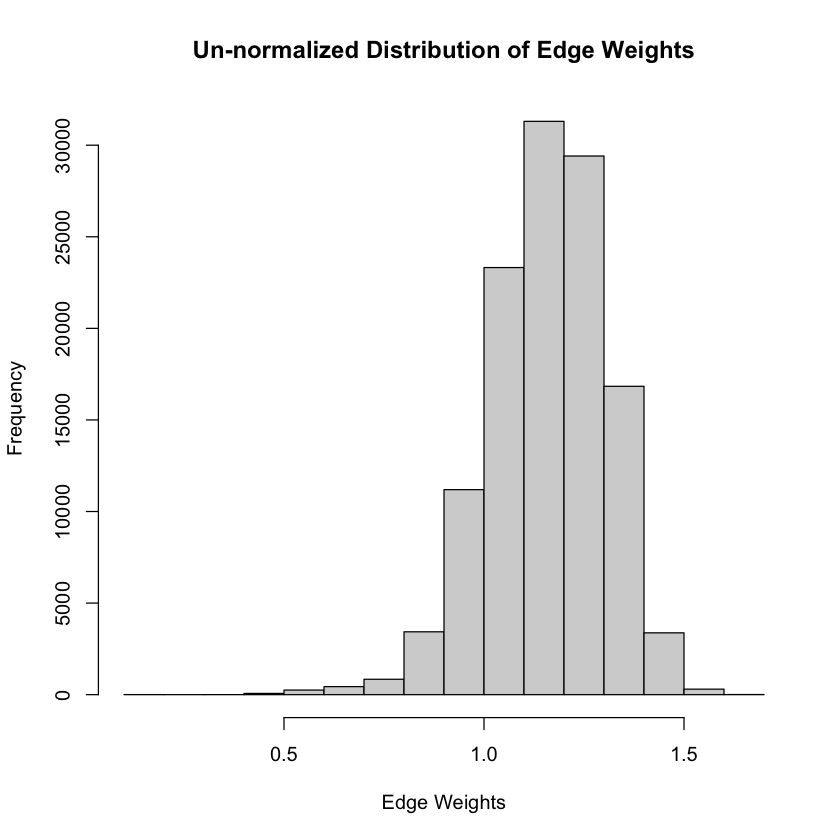

In [107]:
# Plotting the un-normalized distribution of edge weights
hist(elistw[,"wt"],main="Un-normalized Distribution of Edge Weights",xlab="Edge Weights",ylab="Frequency")

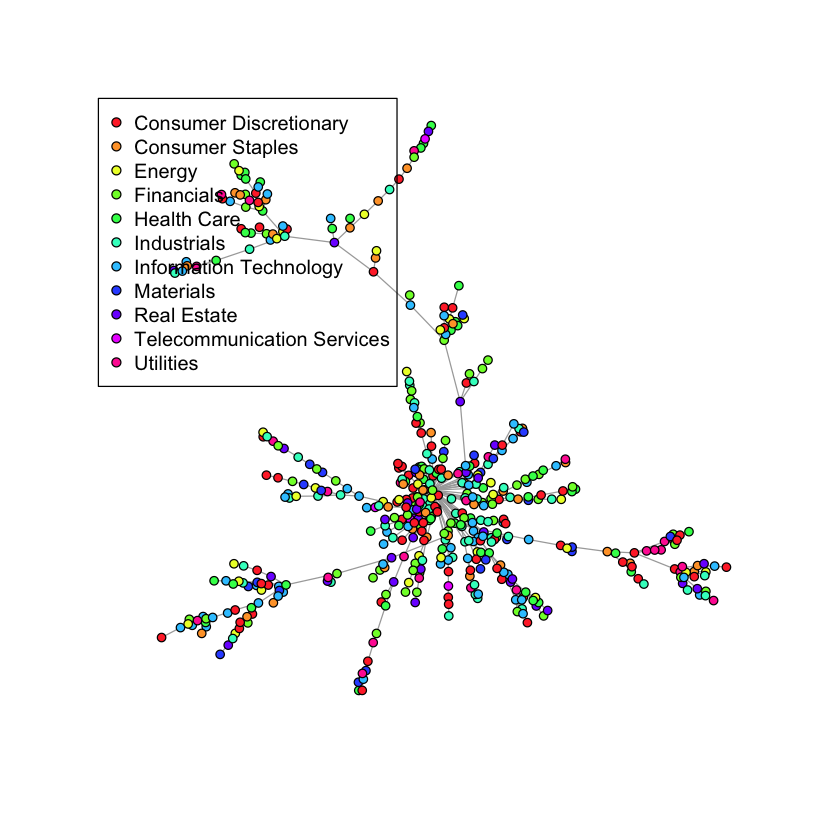

In [108]:
# Extracting and plotting the minimum spanning tree of the correlation graph
mst_gw <- mst(gw)
colbar <- rainbow(num_sector,s = 0.8, v = 1)
plot(mst_gw, vertex.size=3, vertex.label=NA, vertex.color=colbar[sectors.index])
legend('topleft',legend=levels(sector.set),pch=21, pt.bg=colbar)

[1] 55

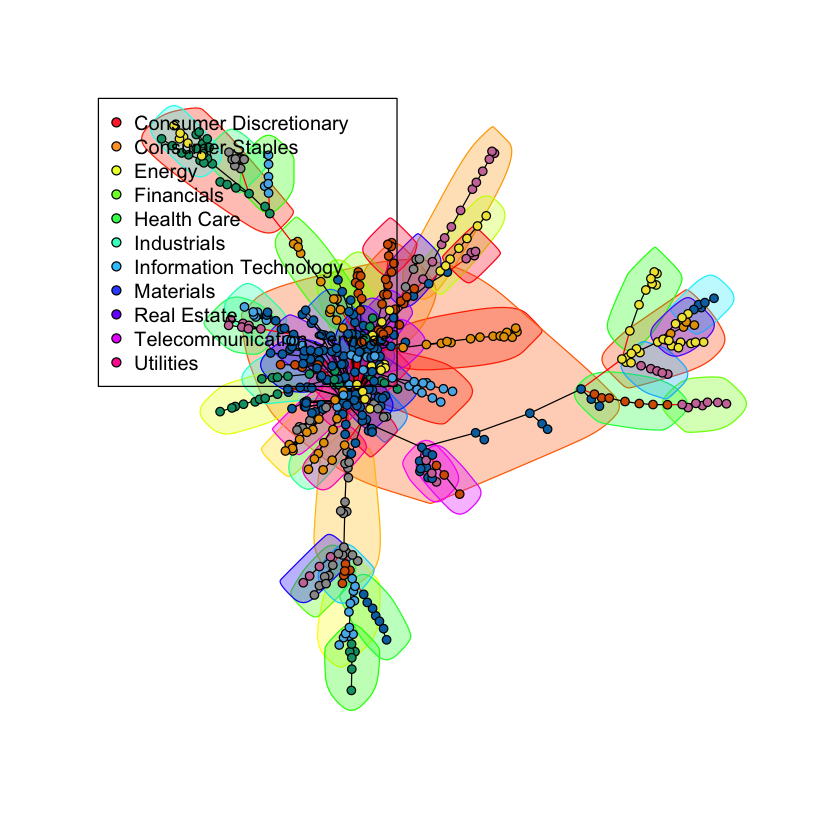

In [109]:
# Clustering of correlation graph
wc_weekly <- walktrap.community(mst_gw, weights= E(mst_gw)$weights, modularity = TRUE) 
length(wc_weekly)
plot(wc_weekly, mst_gw, vertex.size=3, vertex.label=NA, vertex.color=sectors.index)
legend('topleft',legend=levels(sector.set),pch=21, pt.bg=colbar)

In [110]:
# Computing the homogeneity and completeness of the clustering
true<- c(sectors.index)[1:493]
pred <- c(wc_weekly$membership)
homogeneity(true, pred)
completeness(true,pred)

[1] 0.2530779

[1] 0.1656086

In [112]:
card_V = length(V(mst_gw))
sum1 = 0
sum2 = 0
for(v in V(mst_gw)){
    card_N = length(neighbors(mst_gw,v))
    v_sect = sectors.index[v]
    card_Q = 0
    for(n in neighbors(mst_gw, v)){
        if(sectors.index[n] == v_sect){
            card_Q = card_Q + 1
        }
    }
    card_S = length(sectors.index[sectors.index==v_sect])
    p1 = card_Q / card_N
    p2 = card_S / card_V
    sum1 = sum1 + p1
    sum2 = sum2 + p2
}
alpha1 = sum1 / card_V
alpha2 = sum2 / card_V
print("Alpha with first definition of P:")
print(alpha1)
print("Alpha with second definition of P:")
print(alpha2)

[1] "Alpha with first definition of P:"
[1] 0.1287032
[1] "Alpha with second definition of P:"
[1] 0.1144049


QUESTION 7: Repeat questions 2,3,4,5 on the MONTHLY data.

In [113]:
# Processing the files with p,q,r computations for the monthly stock market data
df["Month"]<-months(as.Date(df[,1]))
df["Month_Num"]<-substr(as.Date(df[,1]), 9, 10)

head(df)
L=c()
k=1
matm = matrix(0,length(filenames)-13,142)
for(j in c(1:length(filenames))){
    df = read.csv(filenames[j],header=TRUE, stringsAsFactors=FALSE)
    df["Month"]<-months(as.Date(df[,1])) 
    df["Month_Num"]<-substr(as.Date(df[,1]), 9, 10)
    df <- subset(df, Month_Num=='15')
    L[j] = dim(df)[1]
    if(L[j]==143){
        p = df[,5] 
        q = c()
        r = c()
        for(i in c(2:length(p))){
            q[i-1] = (p[i]-p[i-1])/p[i-1]
        }
        r = log(1+q)
        matm[k,] = r
        k = k+1
    }
}

allcompm = read.csv("finance_data/Name_sector.csv", header=TRUE, stringsAsFactors=FALSE)
allcompm["length"] = L
ind = which(L!=143)
allcompw <- allcompw[-ind,]

,Date,Open,High,Low,Close,Volume,Adj.Close,Day,Month,Month_Num
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>
3,2014-05-05,30.42,30.63,30.11,30.53,4425200,29.81641,Monday,May,05
8,2014-05-12,30.58,30.86,30.55,30.81,1971000,30.08987,Monday,May,12
13,2014-05-19,30.60,30.63,30.28,30.46,3671100,29.74805,Monday,May,19
22,2014-06-02,30.80,30.96,30.65,30.92,3561300,30.19730,Monday,June,02
27,2014-06-09,31.78,32.01,31.65,32.01,3189400,31.26182,Monday,June,09
32,2014-06-16,32.08,32.21,31.99,32.13,2197200,31.37902,Monday,June,16


In [114]:
# Creating the correlation graph
conn <- file("edgelist-monthly.txt", "w")
cal_cor(conn,matm,allcompm)
close(conn)
elistm <-read.delim("edgelist-monthly.txt",header=TRUE)
gm <- graph.data.frame(elistm, directed = FALSE)
E(gm)$weight <- elistm[,"wt"]

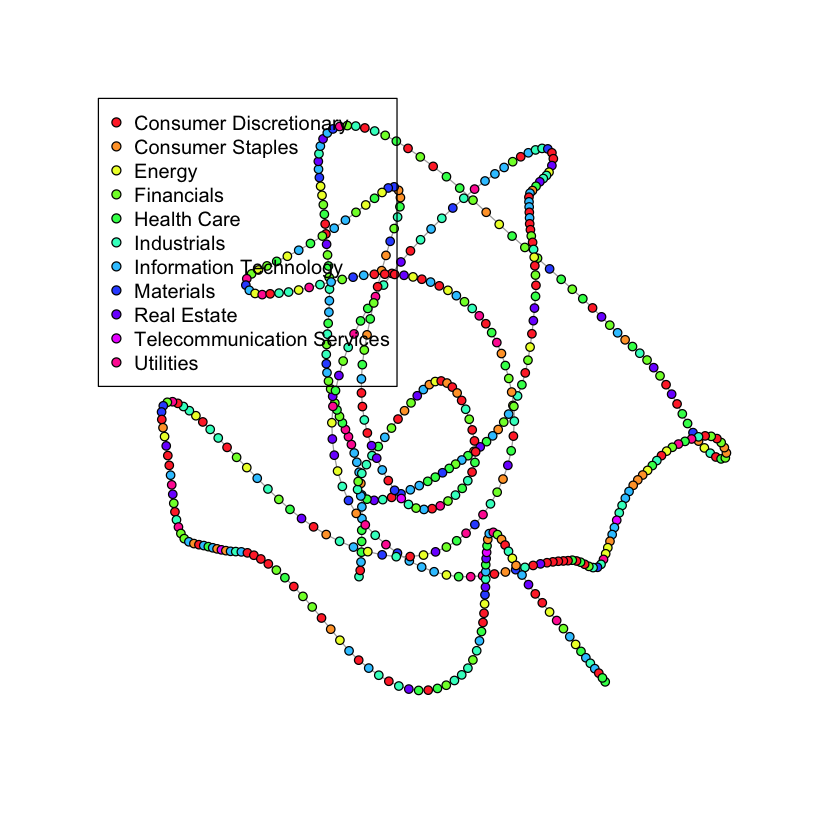

In [115]:
# Extracting and plotting the minimum spanning tree of the correlation graph
mst_gm <- mst(gm)
colbar <- rainbow(num_sector,s = 0.8, v = 1)
plot(mst_gm, vertex.size=3, vertex.label=NA, vertex.color=colbar[sectors.index])
legend('topleft',legend=levels(sector.set),pch=21, pt.bg=colbar)

[1] 24

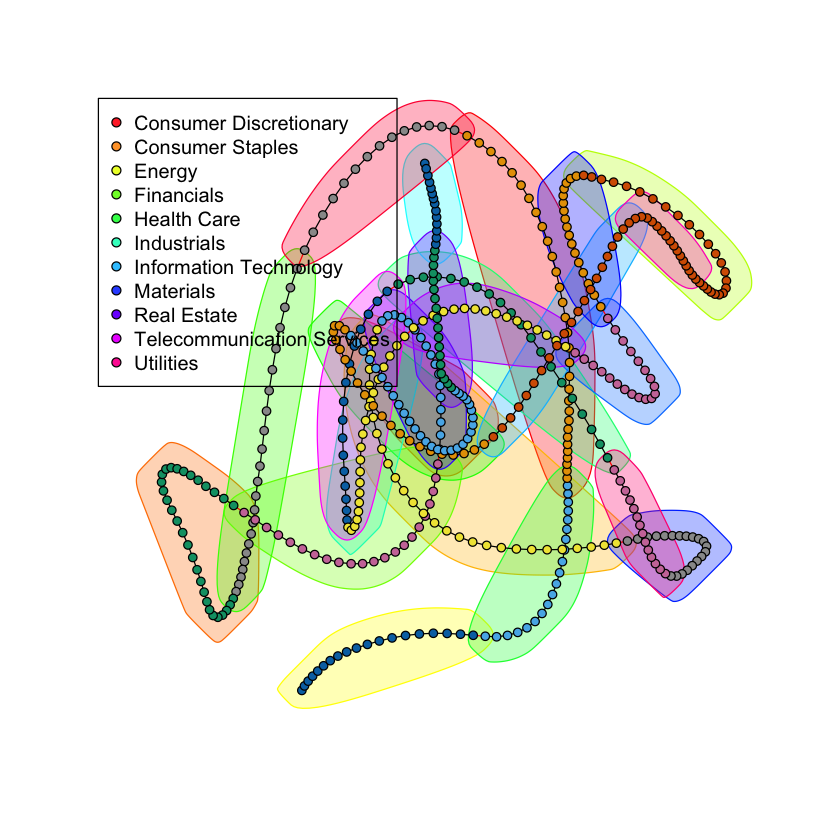

In [116]:
# Clustering of correlation graph
wc_monthly <- walktrap.community(mst_gm, weights= E(mst_gm)$weights, modularity = TRUE) 
length(wc_monthly)
plot(wc_monthly, mst_gm, vertex.size=3, vertex.label=NA, vertex.color=sectors.index)
legend('topleft',legend=levels(sector.set),pch=21, pt.bg=colbar)

In [117]:
# Computing the homogeneity and completeness of the clustering
true<- c(sectors.index)[1:492]

pred <- c(wc_monthly$membership)

homogeneity(true, pred)
completeness(true,pred)

[1] 0.136662

[1] 0.09776118